## Problem Statement:

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.
The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Thumbs up: Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds
- Stop: Pause the movie

In [1]:
import numpy as np
import os
import cv2
import datetime
import os
import abc
from sys import getsizeof
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)


## Dataset Description:
The dataset comprises several hundred video clips, each categorized into one of five distinct classes. These video clips, typically spanning 2-3 seconds in duration, are further divided into sequences of 30 individual frames or images. These videos were recorded by various individuals, each performing one of five specific hand gestures in front of a webcam, akin to the interaction expected with a smart TV.

## Data Location:
The dataset is contained within a zip file, which can be accessed using the following link: [Dataset Zip File](https://drive.google.com/uc?id=1ehyrYBQ5rbQQe6yL4XbLWe3FMvuVUGiL). Inside the zip file, you will find two main folders - 'train' and 'val', each of which contains a CSV file specific to that folder. These folders are further organized into subfolders, with each subfolder representing an individual video of a particular gesture. Each subfolder, which corresponds to a video, contains 30 frames or images. Notably, all images within a specific video subfolder share the same dimensions. However, it's important to note that different videos may have varying dimensions. Videos can be classified into two distinct dimension types: 360x360 or 120x160. This discrepancy is dependent on the type of webcam used to record the videos. Therefore, preprocessing steps will be necessary to standardize the videos for analysis.

## CSV File Details:
Each row of the CSV file associated with the dataset represents a single video. It includes three essential pieces of information:

1. The name of the subfolder that houses the 30 images belonging to that video.
2. The name of the specific hand gesture performed in the video.
3. A numeric label, ranging from 0 to 4, which classifies the video into one of the five predefined categories or classes.

These CSV files play a crucial role in linking the video data to their corresponding categories and labels, facilitating the training and evaluation of machine learning models.

## Read and define the parameters

In [3]:
train_doc = np.random.permutation(open('../input/gesture-recognition/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('../input/gesture-recognition/Project_data/val.csv').readlines())
batch_size = 32
height=100
width=100

In [4]:
def generator(source_path, folder_list, batch_size,height,width):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,5,6,8,10,12,14,18,20,22,24,26,27,28,29] ## image indices
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size
        x = len(img_idx)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,height,width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],1).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shape
                    
                    if image.shape[1] != image.shape[0]: #cropping non square images to square images
                        to_crop = abs(image.shape[1] - image.shape[0])
                        start = to_crop//2
                        end = start + image.shape[0]
                        image = image[:, start:end]
                    
                    image = cv2.resize(image,(width,height), interpolation = cv2.INTER_AREA)
                    image = image - np.percentile(image,5)/ np.percentile(image,95) - np.percentile(image,5)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] 
                    batch_data[folder,idx,:,:,1] = image[:,:,1] 
                    batch_data[folder,idx,:,:,2] = image[:,:,2] 
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        rem_image = len(folder_list)%batch_size
        batch += 1
        if(rem_image!=0):
            batch_data = np.zeros((rem_image,len(img_idx),height,width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((rem_image,5)) # batch_labels is the one hot representation of the output
            for folder in range(rem_image): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],1).astype(np.float32)
                    
                    if image.shape[1] != image.shape[0]: #cropping non square images to square images
                        to_crop = abs(image.shape[1] - image.shape[0])
                        start = to_crop//2
                        end = start + image.shape[0]
                        image = image[:, start:end]
                    
                    image = cv2.resize(image,(width,height), interpolation = cv2.INTER_AREA)
                    image = image - np.percentile(image,5)/ np.percentile(image,95) - np.percentile(image,5) 
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]

                                        
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = '../input/gesture-recognition/Project_data/train'
val_path = '../input/gesture-recognition/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Experiments

### Experiment 1 - Conv3D model with SGD optimizer

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers, layers


#write your model here
model_A1 = Sequential([
    layers.Conv3D(64, (3,3,3), strides=(1,1,1), padding="same", input_shape=(18,100,100,3)),
    layers.BatchNormalization(),
    layers.Activation("elu"),
    # Avoid relu, as it leads to Vanishing Gradient Issue here
    layers.MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)),

    layers.Conv3D(64, (3,3,3), strides=(1,1,1), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("elu"),
    # Avoid relu, as it leads to Vanishing Gradient Issue here
    layers.MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)),


    layers.Conv3D(64, (3,3,3), strides=(1,1,1), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("elu"),
    # Avoid relu, as it leads to Vanishing Gradient Issue here
    layers.MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)),

    layers.Flatten(),
    layers.Dense(512, activation="elu"),
    layers.Dropout(0.5),
    layers.Dense(128, activation="elu"),
    layers.Dropout(0.5),
    layers.Dense(5, activation="softmax")
    
    ])

In [7]:
# Define a learning rate schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9
)

# Create the SGD optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.7, nesterov=True)
model_A1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_A1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 100, 100, 64)  5248      
                                                                 
 batch_normalization (BatchN  (None, 18, 100, 100, 64)  256      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 18, 100, 100, 64)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 50, 50, 64)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 50, 50, 64)     110656    
                                                                 
 batch_normalization_1 (Batc  (None, 9, 50, 50, 64)    2

### Call train and validation generator

In [8]:
train_generator = generator(train_path, train_doc, batch_size,height,width)
val_generator = generator(val_path, val_doc, batch_size,height,width)


In [9]:
for data_test_ in train_generator:
#     print(data_test_)
    print(data_test_[0].shape)
    break

Source path =  ../input/gesture-recognition/Project_data/train ; batch size = 32
(32, 18, 100, 100, 3)


In [10]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1,
                      mode="min", epsilon=0.0001,
                      cooldown=0, min_lr=0.00001)
ES = EarlyStopping(monitor='val_categorical_accuracy', mode = 'max', verbose = 1, patience = 5) #we introduced earlystopping to control training
callbacks_list = [checkpoint, LR, ES]

In [28]:
def validation_train_epoch_steps(batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    
    return steps_per_epoch, validation_steps

In [29]:
steps_per_epoch, validation_steps = validation_train_epoch_steps(batch_size)

In [13]:
history = model_A1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 2.6224 - categorical_accuracy: 0.2866Source path =  ../input/gesture-recognition/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2023-11-0513_32_05.713543/model-00001-2.62244-0.28658-15.81181-0.23000.h5
21/21 [==============================] - 183s 9s/step - loss: 2.6224 - categorical_accuracy: 0.2866 - val_loss: 15.8118 - val_categorical_accuracy: 0.2300 - lr: 9.9979e-04
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.7289 - categorical_accuracy: 0.4374
Epoch 2: saving model to model_init_2023-11-0513_32_05.713543/model-00002-1.72895-0.43741-12.97491-0.19000.h5
21/21 [==============================] - 67s 3s/step - loss: 1.7289 - categorical_accuracy: 0.4374 - val_loss: 12.9749 - val_categorical_accuracy: 0.1900 - lr: 9.9957e-04
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.4785 - categorical_accuracy: 0.4872
Epoch 3: saving model to model_init_2023

In [14]:
def plot_model_performance(history):
    
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    if ES.stopped_epoch == 0:
        epochs_range = range(num_epochs)
    else:
        epochs_range = range(ES.stopped_epoch + 1)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

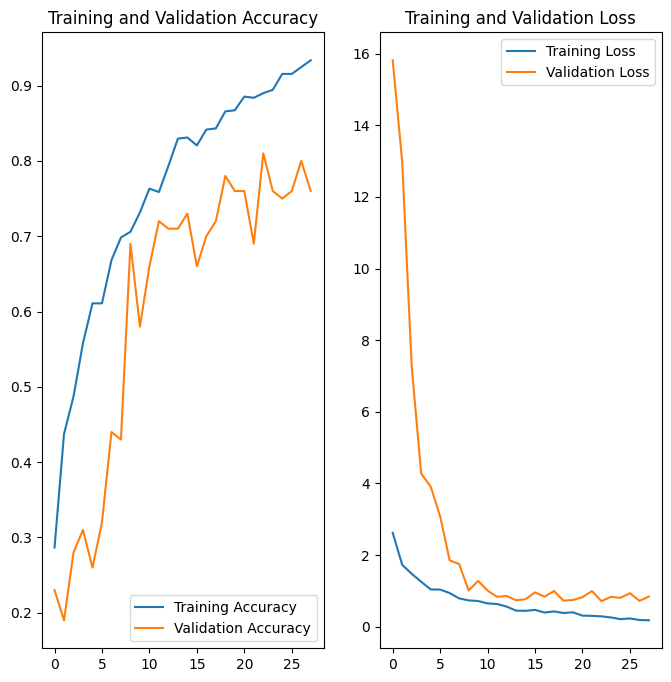

In [15]:
plot_model_performance(history)

### Findings:
The model exhibits strong generalization with a minimal overfitting concern. The training accuracy is commendable, reaching approximately 93%, and the validation accuracy is robust at around 76%. All in all, it stands as a robust and effective model.

### Experiment 2 - Conv3D model with Adam Optimizer

In [16]:
model_A2 = Sequential([
    layers.Conv3D(64, (3,3,3), strides=(1,1,1), padding="same", input_shape=(18,100,100,3)),
    layers.BatchNormalization(),
    layers.Activation("elu"),
    # Avoid relu, as it leads to Vanishing Gradient Issue here
    layers.MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)),

    layers.Conv3D(64, (3,3,3), strides=(1,1,1), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("elu"),
    # Avoid relu, as it leads to Vanishing Gradient Issue here
    layers.MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)),

    layers.Conv3D(64, (3,3,3), strides=(1,1,1), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("elu"),
    # Avoid relu, as it leads to Vanishing Gradient Issue here
    layers.MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)),

    layers.Flatten(),
    layers.Dense(512, activation="elu"),
    layers.Dropout(0.5),
    layers.Dense(128, activation="elu"),
    layers.Dropout(0.5),
    layers.Dense(5, activation="softmax")
    
    ])

In [17]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model_A2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_A2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 18, 100, 100, 64)  5248      
                                                                 
 batch_normalization_3 (Batc  (None, 18, 100, 100, 64)  256      
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 18, 100, 100, 64)  0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 9, 50, 50, 64)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 9, 50, 50, 64)     110656    
                                                                 
 batch_normalization_4 (Batc  (None, 9, 50, 50, 64)   

In [18]:
train_generator = generator(train_path, train_doc, batch_size,height,width)
val_generator = generator(val_path, val_doc, batch_size,height,width)


In [19]:
history = model_A2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  ../input/gesture-recognition/Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 10.2894 - categorical_accuracy: 0.2911Source path =  ../input/gesture-recognition/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2023-11-0513_32_05.713543/model-00001-10.28944-0.29110-329.76495-0.23000.h5
21/21 [==============================] - 70s 3s/step - loss: 10.2894 - categorical_accuracy: 0.2911 - val_loss: 329.7650 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 4.7007 - categorical_accuracy: 0.3605
Epoch 2: saving model to model_init_2023-11-0513_32_05.713543/model-00002-4.70073-0.36048-58.58849-0.18000.h5
21/21 [==============================] - 68s 3s/step - loss: 4.7007 - categorical_accuracy: 0.3605 - val_loss: 58.5885 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 2

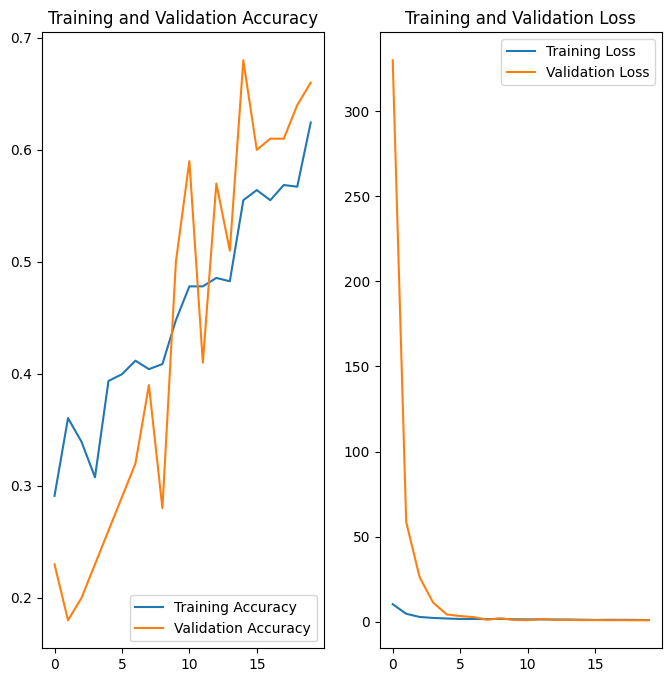

In [20]:
plot_model_performance(history)

### Findings:
- Model slightly overfits withhighly fluctuating training accuracy and validation accuracy
- We may discard this model and continue with Model_A1 and use SGD Optimizer.

##### Let's try to add few more Conv 3D layers on Model 1

### Experiment 3 - Adding 3 more Conv3D layers on Model1 

In [21]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers, layers


#write your model here
model_A3 = Sequential([
    layers.Conv3D(32, (3,3,3), strides=(1,1,1), padding="same", input_shape=(18,100,100,3)),
    layers.BatchNormalization(),
    layers.Activation("elu"),
    # Avoid relu, as it leads to Vanishing Gradient Issue here
    layers.MaxPooling3D(pool_size=(1,2,2), strides=(2,2,2)),

    layers.Conv3D(64, (3,3,3), strides=(1,1,1), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("elu"),
    # Avoid relu, as it leads to Vanishing Gradient Issue here
    layers.MaxPooling3D(pool_size=(1,2,2), strides=(2,2,2)),

    layers.Conv3D(128, (3,3,3), strides=(1,1,1), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("elu"),
    # Avoid relu, as it leads to Vanishing Gradient Issue here
    layers.MaxPooling3D(pool_size=(1,2,2), strides=(2,2,2)),
    
    layers.Conv3D(128, (3,3,3), strides=(1,1,1), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("elu"),
    # Avoid relu, as it leads to Vanishing Gradient Issue here
    layers.MaxPooling3D(pool_size=(1,2,2), strides=(2,2,2)),
    
    layers.Conv3D(256, (2,2,2), strides=(1,1,1), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("elu"),
    # Avoid relu, as it leads to Vanishing Gradient Issue here
    layers.MaxPooling3D(pool_size=(1,2,2), strides=(2,2,2)),
    
    layers.Conv3D(256, (2,2,2), strides=(1,1,1), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("elu"),
    # Avoid relu, as it leads to Vanishing Gradient Issue here
    layers.MaxPooling3D(pool_size=(1,2,2), strides=(2,2,2)),


    layers.Flatten(),
    layers.Dense(1024, activation="elu"),
    layers.Dropout(0.5),
    layers.Dense(512, activation="elu"),
    layers.Dropout(0.5),
    layers.Dense(5, activation="softmax")
    
    ])

In [22]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9
)

# Create the SGD optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.7, nesterov=True)
model_A3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_A3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 18, 100, 100, 32)  2624      
                                                                 
 batch_normalization_6 (Batc  (None, 18, 100, 100, 32)  128      
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 18, 100, 100, 32)  0         
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 9, 50, 50, 32)    0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 9, 50, 50, 64)     55360     
                                                                 
 batch_normalization_7 (Batc  (None, 9, 50, 50, 64)   

In [24]:
train_generator = generator(train_path, train_doc, batch_size,height,width)
val_generator = generator(val_path, val_doc, batch_size,height,width)

In [25]:
history = model_A3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  ../input/gesture-recognition/Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 2.1045 - categorical_accuracy: 0.2836Source path =  ../input/gesture-recognition/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2023-11-0513_32_05.713543/model-00001-2.10447-0.28356-2.06286-0.23000.h5
21/21 [==============================] - 75s 3s/step - loss: 2.1045 - categorical_accuracy: 0.2836 - val_loss: 2.0629 - val_categorical_accuracy: 0.2300 - lr: 9.9979e-04
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.5229 - categorical_accuracy: 0.4057
Epoch 2: saving model to model_init_2023-11-0513_32_05.713543/model-00002-1.52288-0.40573-2.67859-0.26000.h5
21/21 [==============================] - 70s 4s/step - loss: 1.5229 - categorical_accuracy: 0.4057 - val_loss: 2.6786 - val_categorical_accuracy: 0.2600 - lr: 9.9957e-04
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.

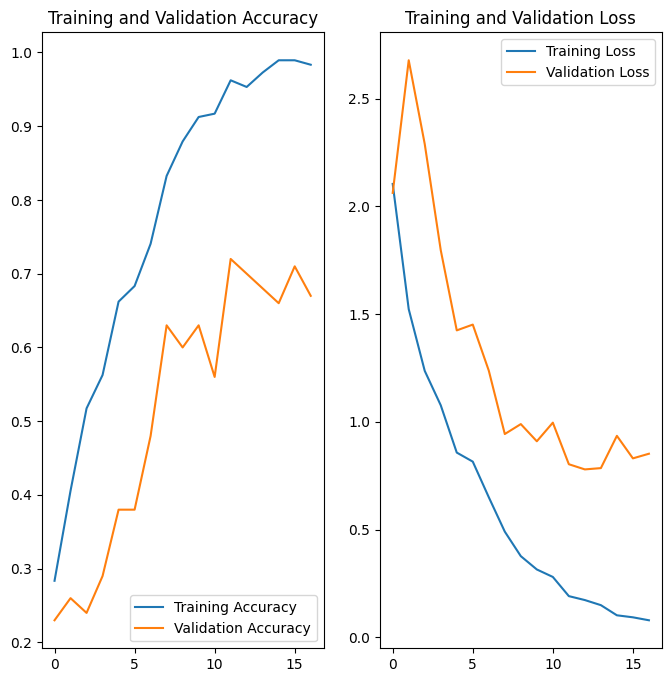

In [26]:
plot_model_performance(history)

### Findings:
Learning rate reduced. Strong training performance (98.34% accuracy, 0.0787 loss), but validation lags (67% accuracy, 0.8519 loss).
While the model excels in training accuracy and loss, there's room for improvement in terms of generalization. Addressing the performance gap between training and validation sets may involve further fine-tuning, regularization techniques, or exploring architectural adjustments.

### Experiment 4 - Model3 with updated kernel_regulizers (L1L2)

In [30]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers, layers
from tensorflow.keras import regularizers

#write your model here
model_A4 = Sequential([
    layers.Conv3D(32, (3,3,3), strides=(1,1,1), padding="same", input_shape=(18,100,100,3)),
    layers.BatchNormalization(),
    layers.Activation("elu"),
    # Avoid relu, as it leads to Vanishing Gradient Issue here
    layers.MaxPooling3D(pool_size=(1,2,2), strides=(2,2,2)),

    layers.Conv3D(64, (3,3,3), strides=(1,1,1), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("elu"),
    # Avoid relu, as it leads to Vanishing Gradient Issue here
    layers.MaxPooling3D(pool_size=(1,2,2), strides=(2,2,2)),

    layers.Conv3D(128, (3,3,3), strides=(1,1,1), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("elu"),
    # Avoid relu, as it leads to Vanishing Gradient Issue here
    layers.MaxPooling3D(pool_size=(1,2,2), strides=(2,2,2)),
    
    layers.Conv3D(128, (3,3,3), strides=(1,1,1), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("elu"),
    # Avoid relu, as it leads to Vanishing Gradient Issue here
    layers.MaxPooling3D(pool_size=(1,2,2), strides=(2,2,2)),
    
    layers.Conv3D(256, (2,2,2), strides=(1,1,1), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("elu"),
    # Avoid relu, as it leads to Vanishing Gradient Issue here
    layers.MaxPooling3D(pool_size=(1,2,2), strides=(2,2,2)),
    
    layers.Conv3D(256, (2,2,2), strides=(1,1,1), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("elu"),
    # Avoid relu, as it leads to Vanishing Gradient Issue here
    layers.MaxPooling3D(pool_size=(1,2,2), strides=(2,2,2)),


    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(1024, activation="elu"),
    layers.Dropout(0.5),
    layers.Dense(512, activation="elu",kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
                 bias_regularizer=regularizers.L2(1e-4),
                 activity_regularizer=regularizers.L2(1e-5)),
    layers.Dense(5, activation="softmax")
    
    ])

In [31]:
num_epochs  = 30
batch_size = 32
train_generator = generator(train_path, train_doc, batch_size,height,width)
val_generator = generator(val_path, val_doc, batch_size,height,width)

In [34]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9
)

# Create the SGD optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.7, nesterov=True)
model_A4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_A4.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 18, 100, 100, 32)  2624      
                                                                 
 batch_normalization_12 (Bat  (None, 18, 100, 100, 32)  128      
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 18, 100, 100, 32)  0         
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 9, 50, 50, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 9, 50, 50, 64)     55360     
                                                                 
 batch_normalization_13 (Bat  (None, 9, 50, 50, 64)   

In [35]:
history = model_A4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 2.3129 - categorical_accuracy: 0.2655Source path =  ../input/gesture-recognition/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2023-11-0513_32_05.713543/model-00001-2.31292-0.26546-2.61384-0.23000.h5
21/21 [==============================] - 82s 4s/step - loss: 2.3129 - categorical_accuracy: 0.2655 - val_loss: 2.6138 - val_categorical_accuracy: 0.2300 - lr: 9.9979e-04
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.7914 - categorical_accuracy: 0.3831
Epoch 2: saving model to model_init_2023-11-0513_32_05.713543/model-00002-1.79136-0.38311-3.03208-0.25000.h5
21/21 [==============================] - 69s 3s/step - loss: 1.7914 - categorical_accuracy: 0.3831 - val_loss: 3.0321 - val_categorical_accuracy: 0.2500 - lr: 9.9957e-04
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.6609 - categorical_accuracy: 0.4299
Epoch 3: saving model to model_init_2023-11-0

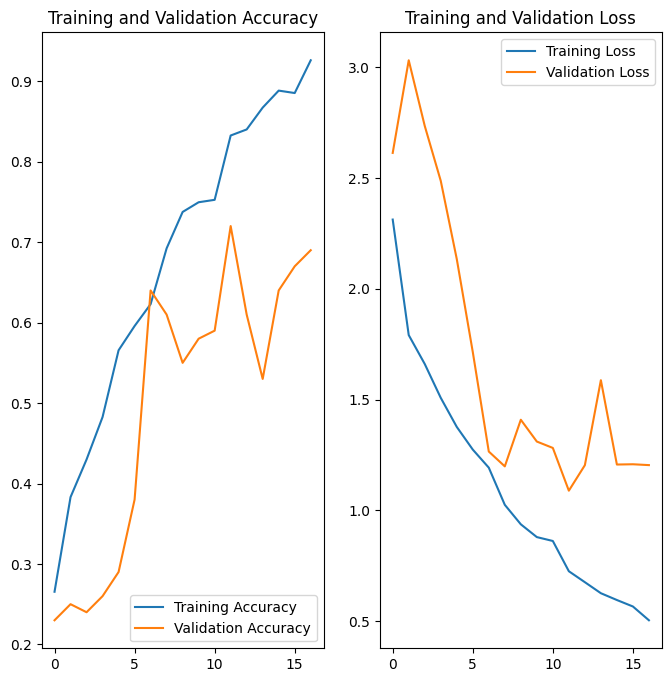

In [36]:
plot_model_performance(history)

#### Training Metrics:

- Loss: The training loss is 0.5037, signifying that the model is effective at minimizing its error during the training phase.
- Categorical Accuracy: The training accuracy is approximately 92.61%, indicating the model's ability to accurately classify training data.

#### Validation Metrics:

- Loss: The validation loss stands at 1.2043, which is higher than the training loss. This discrepancy suggests that the model might be experiencing some degree of overfitting or difficulties in generalizing to unseen data.
- Categorical Accuracy: The validation accuracy is approximately 69%, which is notably lower than the training accuracy. This disparity implies that the model's performance on the validation dataset is not as strong as its performance on the training dataset.

## Experiment 5 - Conv3D with updated image size as 120

### update image size

In [48]:
num_epochs  = 50
batch_size = 32
height = 120
width = 120
train_generator = generator(train_path, train_doc, batch_size,height,width)
val_generator = generator(val_path, val_doc, batch_size,height,width)

In [49]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers, layers
from tensorflow.keras import regularizers

#write your model here
model_A5 = Sequential([
    layers.Conv3D(32, (3,3,3), strides=(1,1,1), padding="same", input_shape=(18,120,120,3)),
    layers.BatchNormalization(),
    layers.Activation("elu"),
    layers.MaxPooling3D(pool_size=(1,2,2)),

    layers.Conv3D(64, (3,3,3), strides=(1,1,1), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("elu"),
    layers.MaxPooling3D(pool_size=(2,2,2)),


    layers.Conv3D(128, (3,3,3), strides=(1,1,1), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("elu"),  
    
    layers.Conv3D(128, (3,3,3), strides=(1,1,1), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("elu"),
    layers.MaxPooling3D(pool_size=(1,2,2)),

    
    layers.Conv3D(256, (2,2,2), strides=(1,1,1), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("elu"),
    
    layers.Conv3D(256, (2,2,2), strides=(1,1,1), padding="same"),
    layers.BatchNormalization(),
    layers.Activation("elu"),
    layers.MaxPooling3D(pool_size=(2,2,2)),


    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(256, activation="relu"),
    layers.Dense(5, activation="softmax")
    
    ])

In [50]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9
)

# Create the SGD optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.7, nesterov=True)
model_A5.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_A5.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_30 (Conv3D)          (None, 18, 120, 120, 32)  2624      
                                                                 
 batch_normalization_30 (Bat  (None, 18, 120, 120, 32)  128      
 chNormalization)                                                
                                                                 
 activation_30 (Activation)  (None, 18, 120, 120, 32)  0         
                                                                 
 max_pooling3d_26 (MaxPoolin  (None, 18, 60, 60, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_31 (Conv3D)          (None, 18, 60, 60, 64)    55360     
                                                                 
 batch_normalization_31 (Bat  (None, 18, 60, 60, 64)  

In [51]:
steps_per_epoch, validation_steps = validation_train_epoch_steps(batch_size)

In [52]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1,
                      mode="min", epsilon=0.0001,
                      cooldown=0, min_lr=0.00001)
ES = EarlyStopping(monitor='val_categorical_accuracy', mode = 'max', verbose = 1, patience = 5)
callbacks_list = [checkpoint, LR, ES]

In [53]:
history = model_A5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../input/gesture-recognition/Project_data/train ; batch size = 32
Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 2.5262 - categorical_accuracy: 0.3243Source path =  ../input/gesture-recognition/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2023-11-0513_32_05.713543/model-00001-2.52622-0.32428-5.58246-0.27000.h5
21/21 [==============================] - 72s 3s/step - loss: 2.5262 - categorical_accuracy: 0.3243 - val_loss: 5.5825 - val_categorical_accuracy: 0.2700 - lr: 9.9979e-04
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.2860 - categorical_accuracy: 0.4691
Epoch 2: saving model to model_init_2023-11-0513_32_05.713543/model-00002-1.28601-0.46908-4.36091-0.20000.h5
21/21 [==============================] - 70s 3s/step - loss: 1.2860 - categorical_accuracy: 0.4691 - val_loss: 4.3609 - val_categorical_accuracy: 0.2000 - lr: 9.9957e-04
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 1.

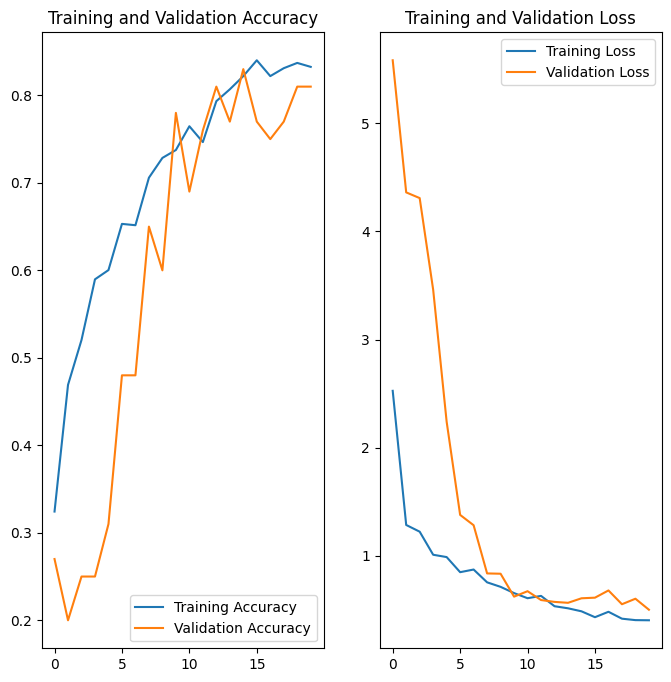

In [54]:
plot_model_performance(history)

At epoch 20, several key observations can be made regarding the model:

1. **Model Saving**: The model checkpoint callback saved the model to a file named "model-00020-0.40478-0.83258-0.50246-0.81000.h5," capturing the model's state at this checkpoint.

2. **Training Metrics**:
   - **Loss**: The training loss is 0.4048, indicating that the model continues to effectively minimize its error during the training phase.
   - **Categorical Accuracy**: The training accuracy is approximately 83.26%, suggesting that the model is capable of accurately classifying the training data.

3. **Validation Metrics**:
   - **Loss**: The validation loss is 0.5025, which is close to the training loss. This suggests that the model is not significantly overfitting and maintains a relatively consistent performance on the validation dataset.
   - **Categorical Accuracy**: The validation accuracy is approximately 81%, indicating that the model's performance on the validation dataset is also strong and comparable to its training accuracy.

4. **Learning Rate**: The learning rate (lr) remains dynamically adjusted during training and is at approximately 9.9560e-04.

Overall, the model displays effective training performance and strong generalization to the validation dataset, as indicated by the convergence of training and validation metrics. This signifies that the model has likely reached a good level of performance by epoch 20.

# Model Type B

## Experiment 1 - Conv2D with GRU

In [58]:
batch_size=20 
num_epochs=50
height,width=120,120

In [59]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers, layers
from keras.regularizers import l2
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN

modelB1 = Sequential([
    layers.TimeDistributed(Conv2D(16, (2, 2), padding='same'),input_shape=(18,height,width,3)),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.TimeDistributed(Conv2D(16, (2, 2))),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.TimeDistributed(MaxPooling2D(pool_size=(2, 2))),
    layers.Dropout(0.2),                    
    layers.TimeDistributed(Conv2D(16, (2, 2), padding='same')),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.TimeDistributed(Conv2D(32, (2, 2), padding='same')),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.TimeDistributed(MaxPooling2D(pool_size=(2, 2))),
    layers.Dropout(0.2),
    layers.TimeDistributed(Flatten()),
    layers.GRU(32, return_sequences=False, dropout=0.25),
    layers.Dense(512,kernel_regularizer=l2(0.01)),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(5, activation="softmax")])

In [61]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9
)

# Create the SGD optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.7, nesterov=True)
modelB1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (modelB1.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_7 (TimeDis  (None, 18, 120, 120, 16)  208      
 tributed)                                                       
                                                                 
 activation_41 (Activation)  (None, 18, 120, 120, 16)  0         
                                                                 
 batch_normalization_41 (Bat  (None, 18, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 time_distributed_8 (TimeDis  (None, 18, 119, 119, 16)  1040     
 tributed)                                                       
                                                                 
 activation_42 (Activation)  (None, 18, 119, 119, 16)  0         
                                                      

In [62]:
train_generator = generator(train_path, train_doc, batch_size,height,width)
val_generator = generator(val_path, val_doc, batch_size,height,width)

In [63]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.000001)

ES = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1, patience=5)

callbacks_list = [checkpoint, LR, ES]

In [64]:
steps_per_epoch, validation_steps = validation_train_epoch_steps(batch_size)

In [66]:
historyb1 = modelB1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../input/gesture-recognition/Project_data/train ; batch size = 20
Epoch 1/50
34/34 [==============================] - ETA: 0s - loss: 2.4219 - categorical_accuracy: 0.3032Source path =  ../input/gesture-recognition/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2023-11-0513_32_05.713543/model-00001-2.42189-0.30317-2.22516-0.20000.h5
34/34 [==============================] - 90s 3s/step - loss: 2.4219 - categorical_accuracy: 0.3032 - val_loss: 2.2252 - val_categorical_accuracy: 0.2000 - lr: 9.9965e-04
Epoch 2/50
34/34 [==============================] - ETA: 0s - loss: 1.9546 - categorical_accuracy: 0.4178
Epoch 2: saving model to model_init_2023-11-0513_32_05.713543/model-00002-1.95463-0.41780-2.21164-0.16000.h5
34/34 [==============================] - 71s 2s/step - loss: 1.9546 - categorical_accuracy: 0.4178 - val_loss: 2.2116 - val_categorical_accuracy: 0.1600 - lr: 9.9929e-04
Epoch 3/50
34/34 [==============================] - ETA: 0s - loss: 1.

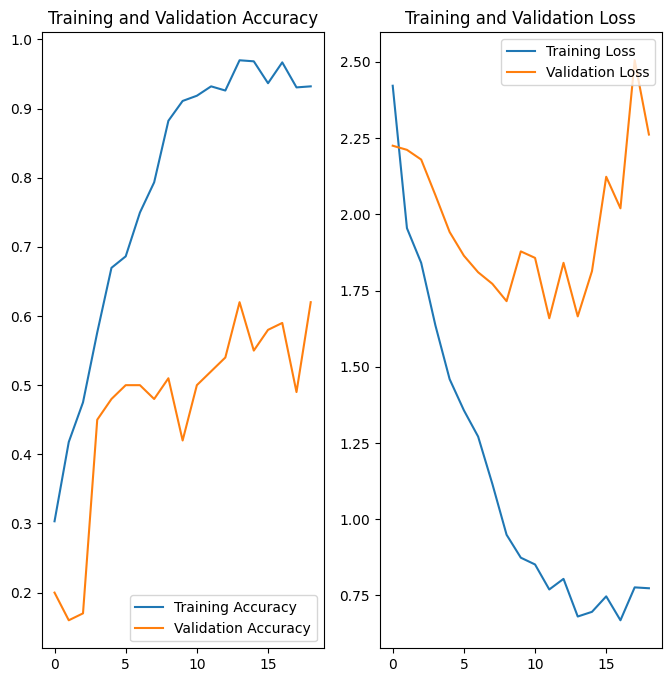

In [68]:
plot_model_performance(historyb1)

At epoch 19, several important insights can be gathered regarding the model's performance:

1. **Model Saving**: The model checkpoint callback saved the model to a file named "model-00019-0.77342-0.93213-2.26179-0.62000.h5," preserving the model's state at this specific checkpoint.

2. **Training Metrics**:
   - **Loss**: The training loss is 0.7734, indicating that the model was experiencing a relatively higher error during the training phase at this epoch.
   - **Categorical Accuracy**: The training accuracy is quite high, at approximately 93.21%. This suggests that the model is proficient at accurately classifying the training data.

3. **Validation Metrics**:
   - **Loss**: The validation loss is notably higher at 2.2618 compared to the training loss. This substantial discrepancy suggests that the model might be overfitting and struggling to generalize effectively to unseen data.
   - **Categorical Accuracy**: The validation accuracy is approximately 62%, which is significantly lower than the training accuracy. This performance gap indicates that the model's generalization to the validation dataset is not as strong as its performance on the training dataset.

4. **Learning Rate**: The learning rate (lr) remains dynamically adjusted during training and is at approximately 9.9323e-04.

In summary, the model exhibits strong training accuracy but appears to face challenges with generalization to the validation dataset. The significant performance gap between the training and validation datasets, as well as the high validation loss, suggests that further adjustments and regularization techniques may be necessary to improve the model's generalization capability.

## Experiment 2 - Conv2D + LSTM

In [69]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers, layers
from keras.regularizers import l2
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN

modelB2 = Sequential([
    layers.TimeDistributed(Conv2D(16, (2, 2), padding='same'),input_shape=(18,height,width,3)),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.TimeDistributed(MaxPooling2D((2, 2))),
    layers.TimeDistributed(Conv2D(32, (2, 2))),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.TimeDistributed(MaxPooling2D((2, 2))),
    layers.TimeDistributed(Conv2D(64, (2, 2), padding='same')),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.TimeDistributed(MaxPooling2D((2, 2))),
    layers.TimeDistributed(Conv2D(128, (2, 2), padding='same')),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.TimeDistributed(MaxPooling2D((2, 2))),
    layers.TimeDistributed(Conv2D(256, (2, 2), padding='same')),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.TimeDistributed(MaxPooling2D((2, 2))),
    layers.TimeDistributed(Flatten()),
    layers.LSTM(64, return_sequences=False, dropout=0.25),
    layers.Dense(64,kernel_regularizer=l2(0.01)),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(5, activation="softmax")])

In [75]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9
)

# Create the SGD optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.7, nesterov=True)
modelB2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (modelB2.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_14 (TimeDi  (None, 18, 120, 120, 16)  208      
 stributed)                                                      
                                                                 
 activation_46 (Activation)  (None, 18, 120, 120, 16)  0         
                                                                 
 batch_normalization_46 (Bat  (None, 18, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 time_distributed_15 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 18, 59, 59, 32)   2080      
 stributed)                                           

In [76]:
train_generator = generator(train_path, train_doc, batch_size,height,width)
val_generator = generator(val_path, val_doc, batch_size,height,width)

In [77]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.000001)

ES = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1, patience=5)

callbacks_list = [checkpoint, LR, ES]

In [78]:
steps_per_epoch, validation_steps = validation_train_epoch_steps(batch_size)

In [79]:
historyb1 = modelB2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../input/gesture-recognition/Project_data/train ; batch size = 20
Epoch 1/50
34/34 [==============================] - ETA: 0s - loss: 2.6698 - categorical_accuracy: 0.2911Source path =  ../input/gesture-recognition/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2023-11-0513_32_05.713543/model-00001-2.66982-0.29110-2.41165-0.17000.h5
34/34 [==============================] - 87s 3s/step - loss: 2.6698 - categorical_accuracy: 0.2911 - val_loss: 2.4117 - val_categorical_accuracy: 0.1700 - lr: 9.9965e-04
Epoch 2/50
34/34 [==============================] - ETA: 0s - loss: 2.0726 - categorical_accuracy: 0.4419
Epoch 2: saving model to model_init_2023-11-0513_32_05.713543/model-00002-2.07259-0.44193-2.28313-0.20000.h5
34/34 [==============================] - 71s 2s/step - loss: 2.0726 - categorical_accuracy: 0.4419 - val_loss: 2.2831 - val_categorical_accuracy: 0.2000 - lr: 9.9929e-04
Epoch 3/50
34/34 [==============================] - ETA: 0s - loss: 1.

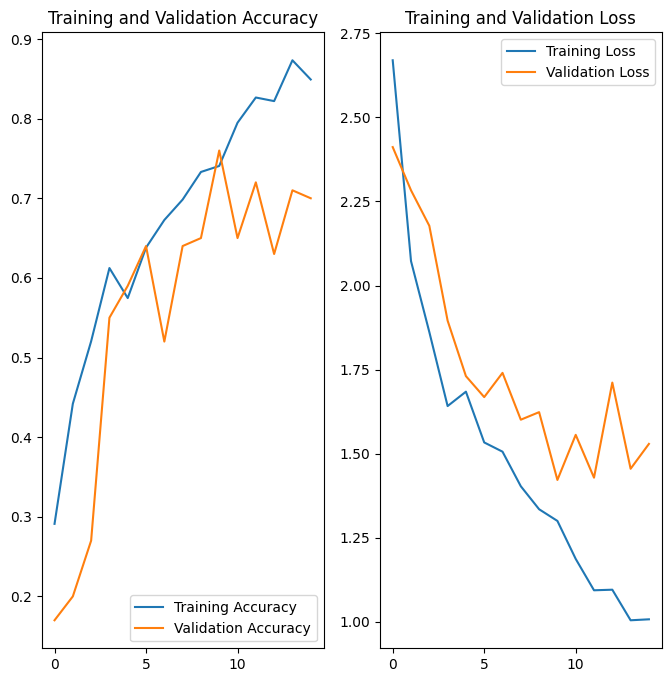

In [80]:
plot_model_performance(historyb1)

In epoch 15, several important findings can be observed regarding the model's performance:

1. **Model Saving**: The model checkpoint callback saved the model to a file named "model-00015-1.00739-0.84917-1.52902-0.70000.h5," capturing the model's state at this specific checkpoint.

2. **Training Metrics**:
   - **Loss**: The training loss is 1.0074, indicating that the model had a relatively higher training error during this epoch.
   - **Categorical Accuracy**: The training accuracy is approximately 84.92%, indicating the model's proficiency in accurately classifying the training data.

3. **Validation Metrics**:
   - **Loss**: The validation loss is 1.5290, which is notably higher than the training loss. This discrepancy suggests that the model might be overfitting and facing challenges in generalizing effectively to unseen data.
   - **Categorical Accuracy**: The validation accuracy is approximately 70%, which is lower than the training accuracy. This performance gap highlights that the model's generalization to the validation dataset is not as strong as its performance on the training dataset.

4. **Learning Rate**: The learning rate (lr) remains dynamically adjusted during training and stands at approximately 9.9465e-04.

In summary, the model exhibits good training accuracy but faces challenges with generalization to the validation dataset. The performance gap between the training and validation datasets, as well as the higher validation loss, suggests that further fine-tuning and regularization techniques may be needed to enhance the model's generalization capability.

## Experiment 3 - Conv2D + LSTM (with Regularization)

In [81]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers, layers
from keras.regularizers import l2
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN

modelB3= Sequential([
    layers.TimeDistributed(Conv2D(16, (2, 2), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), padding='same'),input_shape=(18,height,width,3)),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.TimeDistributed(MaxPooling2D((2, 2))),
    layers.TimeDistributed(Conv2D(32, (2, 2),kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.TimeDistributed(MaxPooling2D(pool_size=(2, 2))),
    layers.Dropout(0.2),                    
    layers.TimeDistributed(Conv2D(64, (2, 2), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),padding='same')),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.TimeDistributed(MaxPooling2D((2, 2))),
    layers.TimeDistributed(Conv2D(128, (2, 2),kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), padding='same')),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.TimeDistributed(MaxPooling2D(pool_size=(2, 2))),
    layers.Dropout(0.2),
    layers.TimeDistributed(Conv2D(256, (2, 2), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),padding='same')),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.TimeDistributed(MaxPooling2D(pool_size=(2, 2))),
    layers.Dropout(0.2),
    layers.TimeDistributed(Flatten()),
    layers.LSTM(64, return_sequences=False, dropout=0.25),
    layers.Dense(64,kernel_regularizer=l2(0.01)),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(5, activation="softmax")])

In [82]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9
)

# Create the SGD optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.7, nesterov=True)
modelB3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (modelB3.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_25 (TimeDi  (None, 18, 120, 120, 16)  208      
 stributed)                                                      
                                                                 
 activation_52 (Activation)  (None, 18, 120, 120, 16)  0         
                                                                 
 batch_normalization_52 (Bat  (None, 18, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 time_distributed_26 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 18, 59, 59, 32)   2080      
 stributed)                                          

In [83]:
train_generator = generator(train_path, train_doc, batch_size,height,width)
val_generator = generator(val_path, val_doc, batch_size,height,width)

In [84]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.000001)

ES = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1, patience=5)

callbacks_list = [checkpoint, LR, ES]

In [85]:
steps_per_epoch, validation_steps = validation_train_epoch_steps(batch_size)

In [86]:
historyb1 = modelB3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../input/gesture-recognition/Project_data/train ; batch size = 20
Epoch 1/50
34/34 [==============================] - ETA: 0s - loss: 5.8885 - categorical_accuracy: 0.2790Source path =  ../input/gesture-recognition/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2023-11-0513_32_05.713543/model-00001-5.88847-0.27903-5.52402-0.24000.h5
34/34 [==============================] - 75s 2s/step - loss: 5.8885 - categorical_accuracy: 0.2790 - val_loss: 5.5240 - val_categorical_accuracy: 0.2400 - lr: 9.9965e-04
Epoch 2/50
34/34 [==============================] - ETA: 0s - loss: 5.6505 - categorical_accuracy: 0.3213
Epoch 2: saving model to model_init_2023-11-0513_32_05.713543/model-00002-5.65052-0.32127-5.50369-0.28000.h5
34/34 [==============================] - 70s 2s/step - loss: 5.6505 - categorical_accuracy: 0.3213 - val_loss: 5.5037 - val_categorical_accuracy: 0.2800 - lr: 9.9929e-04
Epoch 3/50
34/34 [==============================] - ETA: 0s - loss: 5.

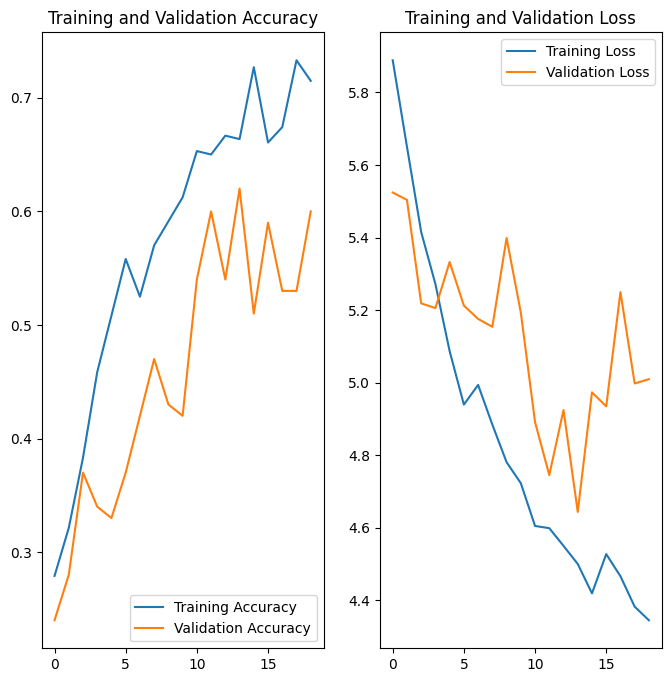

In [87]:
plot_model_performance(historyb1)

In epoch 19, several findings can be observed regarding the model's performance:

1. **Model Saving**: The model checkpoint callback saved the model to a file named "model-00019-4.34519-0.71493-5.00961-0.60000.h5," capturing the model's state at this specific checkpoint.

2. **Training Metrics**:
   - **Loss**: The training loss is notably high at 4.3452, indicating that the model had a substantial training error during this epoch.
   - **Categorical Accuracy**: The training accuracy is approximately 71.49%, suggesting that the model achieved an accuracy of around 71.49% on the training data during this epoch.

3. **Validation Metrics**:
   - **Loss**: The validation loss is even higher at 5.0096, significantly surpassing the training loss. This substantial gap indicates that the model may be overfitting and encountering difficulties in generalizing effectively to unseen data.
   - **Categorical Accuracy**: The validation accuracy is approximately 60%, which is lower than the training accuracy. This performance gap underscores that the model's generalization to the validation dataset is not as strong as its performance on the training dataset.

4. **Learning Rate**: The learning rate (lr) remains dynamically adjusted during training and stands at approximately 9.9323e-04.

The model's performance in this epoch appears to be suboptimal, as indicated by the high losses and the significant gap between the training and validation metrics. Further analysis, model adjustments, and regularization techniques are likely needed to enhance the model's generalization to unseen data.

For the model summary, you can provide the architecture and configuration of the model, including the number of layers, layer types, and parameter counts. This information is crucial for a more detailed analysis of the model's structure and potential areas for improvement.

## Experiment 4 - Transfer Learning + LSTM

In [88]:
batch_size=20 # setting for Part B
num_epochs=50
height,width=120,120

In [89]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers, layers
from keras.regularizers import l2
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from tensorflow.keras.applications import MobileNetV2

In [90]:
base_modelB4 = tf.keras.applications.MobileNetV2(input_shape=(height,width,3),include_top=False,weights='imagenet')
modelB4 = tf.keras.Sequential()
modelB4.add(TimeDistributed(base_modelB4,input_shape=(18,height,width,3)))
modelB4.add(TimeDistributed(BatchNormalization()))
modelB4.add(TimeDistributed(MaxPooling2D((2, 2))))
modelB4.add(TimeDistributed(Flatten()))
modelB4.add(LSTM(128))
modelB4.add(Dropout(0.25))
modelB4.add(Dense(64,activation='relu'))
modelB4.add(Dropout(0.25))
modelB4.add(Dense(5, activation='softmax'))

9406464/9406464 [==============================] - 0s 0us/step


In [94]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9
)

# Create the SGD optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.7, nesterov=True)
modelB4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (modelB4.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_36 (TimeDi  (None, 18, 4, 4, 1280)   2257984   
 stributed)                                                      
                                                                 
 time_distributed_37 (TimeDi  (None, 18, 4, 4, 1280)   5120      
 stributed)                                                      
                                                                 
 time_distributed_38 (TimeDi  (None, 18, 2, 2, 1280)   0         
 stributed)                                                      
                                                                 
 time_distributed_39 (TimeDi  (None, 18, 5120)         0         
 stributed)                                                      
                                                                 
 lstm_2 (LSTM)               (None, 128)             

In [95]:
train_generator = generator(train_path, train_doc, batch_size,height,width)
val_generator = generator(val_path, val_doc, batch_size,height,width)

In [96]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.000001)

ES = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1, patience=5)

callbacks_list = [checkpoint, LR, ES]

In [97]:
historyb4 = modelB4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Source path =  ../input/gesture-recognition/Project_data/train ; batch size = 20
Epoch 1/50
34/34 [==============================] - ETA: 0s - loss: 1.6487 - categorical_accuracy: 0.2308Source path =  ../input/gesture-recognition/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2023-11-0513_32_05.713543/model-00001-1.64868-0.23077-1.57759-0.26000.h5
34/34 [==============================] - 91s 2s/step - loss: 1.6487 - categorical_accuracy: 0.2308 - val_loss: 1.5776 - val_categorical_accuracy: 0.2600 - lr: 9.9965e-04
Epoch 2/50
34/34 [==============================] - ETA: 0s - loss: 1.4536 - categorical_accuracy: 0.3529
Epoch 2: saving model to model_init_2023-11-0513_32_05.713543/model-00002-1.45364-0.35294-1.56998-0.26000.h5
34/34 [==============================] - 72s 2s/step - loss: 1.4536 - categorical_accuracy: 0.3529 - val_loss: 1.5700 - val_categorical_accuracy: 0.2600 - lr: 9.9929e-04
Epoch 3/50
34/34 [==============================] - ETA: 0s - loss: 1.

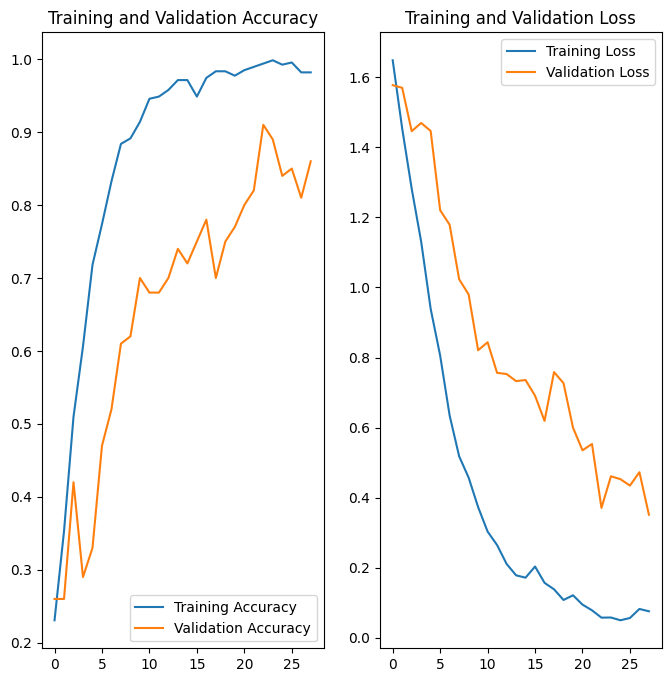

In [98]:
plot_model_performance(historyb4)

## Conclusions

The model follows a sequential architecture with various layers, including TimeDistributed, LSTM, Dropout, and Dense layers. It has a total of approximately 4,959,173 parameters, of which 4,922,501 are trainable.

- In epoch 28, the model achieved outstanding results:
- Training Loss: 0.0755, Training Accuracy: 98.19%
- Validation Loss: 0.3512, Validation Accuracy: 86%

This suggests the model's proficiency in minimizing error and achieving high accuracy, making it a strong performer.

**We will choose the last model which is Transfer learning + LSTM, as it is giving the best performance.**